In [738]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [739]:
df = pd.read_csv('data.csv')
df.time = df.time - df.time[0]

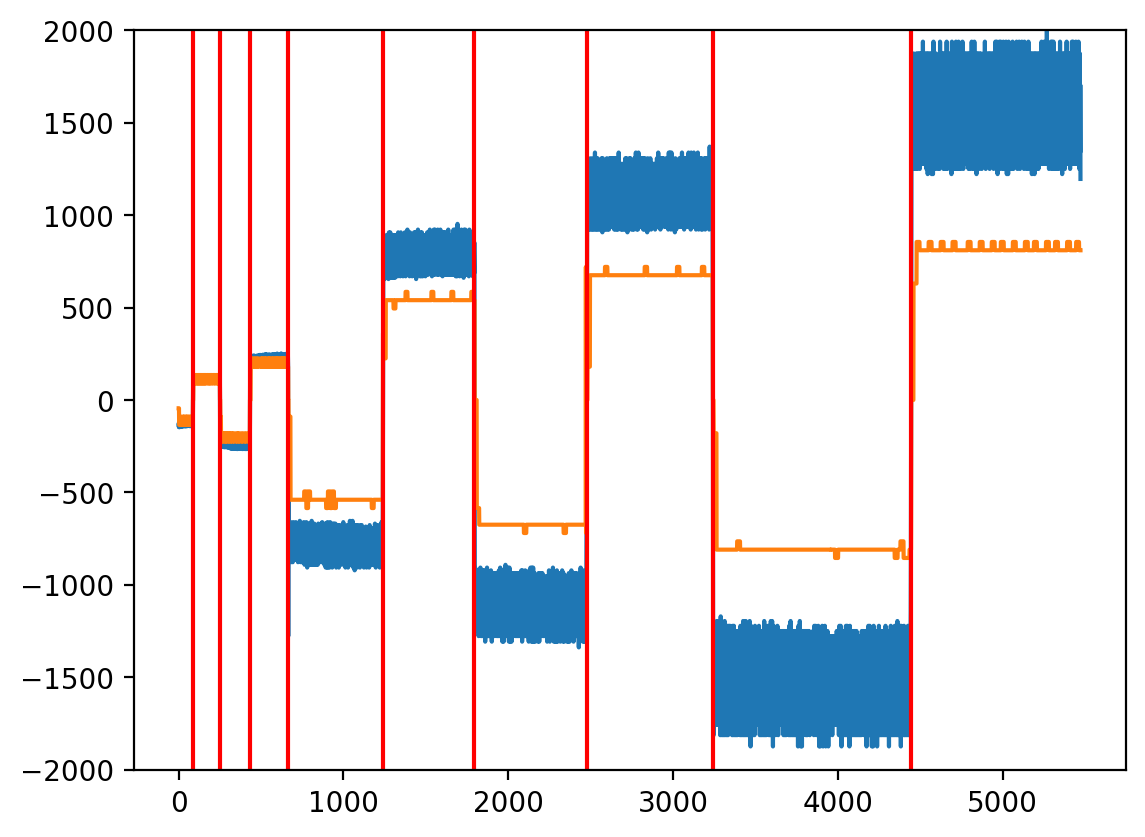

In [740]:
# detect experiment change as zero crossing task
zero_crossings = np.where(np.diff(np.sign(df.vel_pt)))[0]

plt.plot(df.vel_pt)
plt.plot(df.vel_pc)
plt.ylim(-2000, 2000)
for x in zero_crossings:
    plt.vlines(x, -2000, 2000, color='r')

In [741]:
import itertools

last = 0
exp_indeces = []
for idx, x in enumerate(zero_crossings):
    # Remove values on border, when experiments were switching
    if idx < 5:
        border = 15
    else:
        border = 35
    exp_indeces.append((last + border, x - border))
    last = x 
    
exp_indeces.append((last + border, len(df) - border))
exp_names = list(itertools.chain(*[[f"-vel{i}", f"vel_{i}"] for i in range(5)]))

In [742]:
ref_speeds = []
for (st, en), name in zip(exp_indeces, exp_names):
    st_t, en_t = df.time[st]/1e3, df.time[en]/1e3
    time = en_t - st_t
    counts = df.total_count[en] - df.total_count[st]
    ref_speed = counts*360/time
    ref_speeds.append(ref_speed)

Text(0, 0.5, 'Velocity, deg/s')

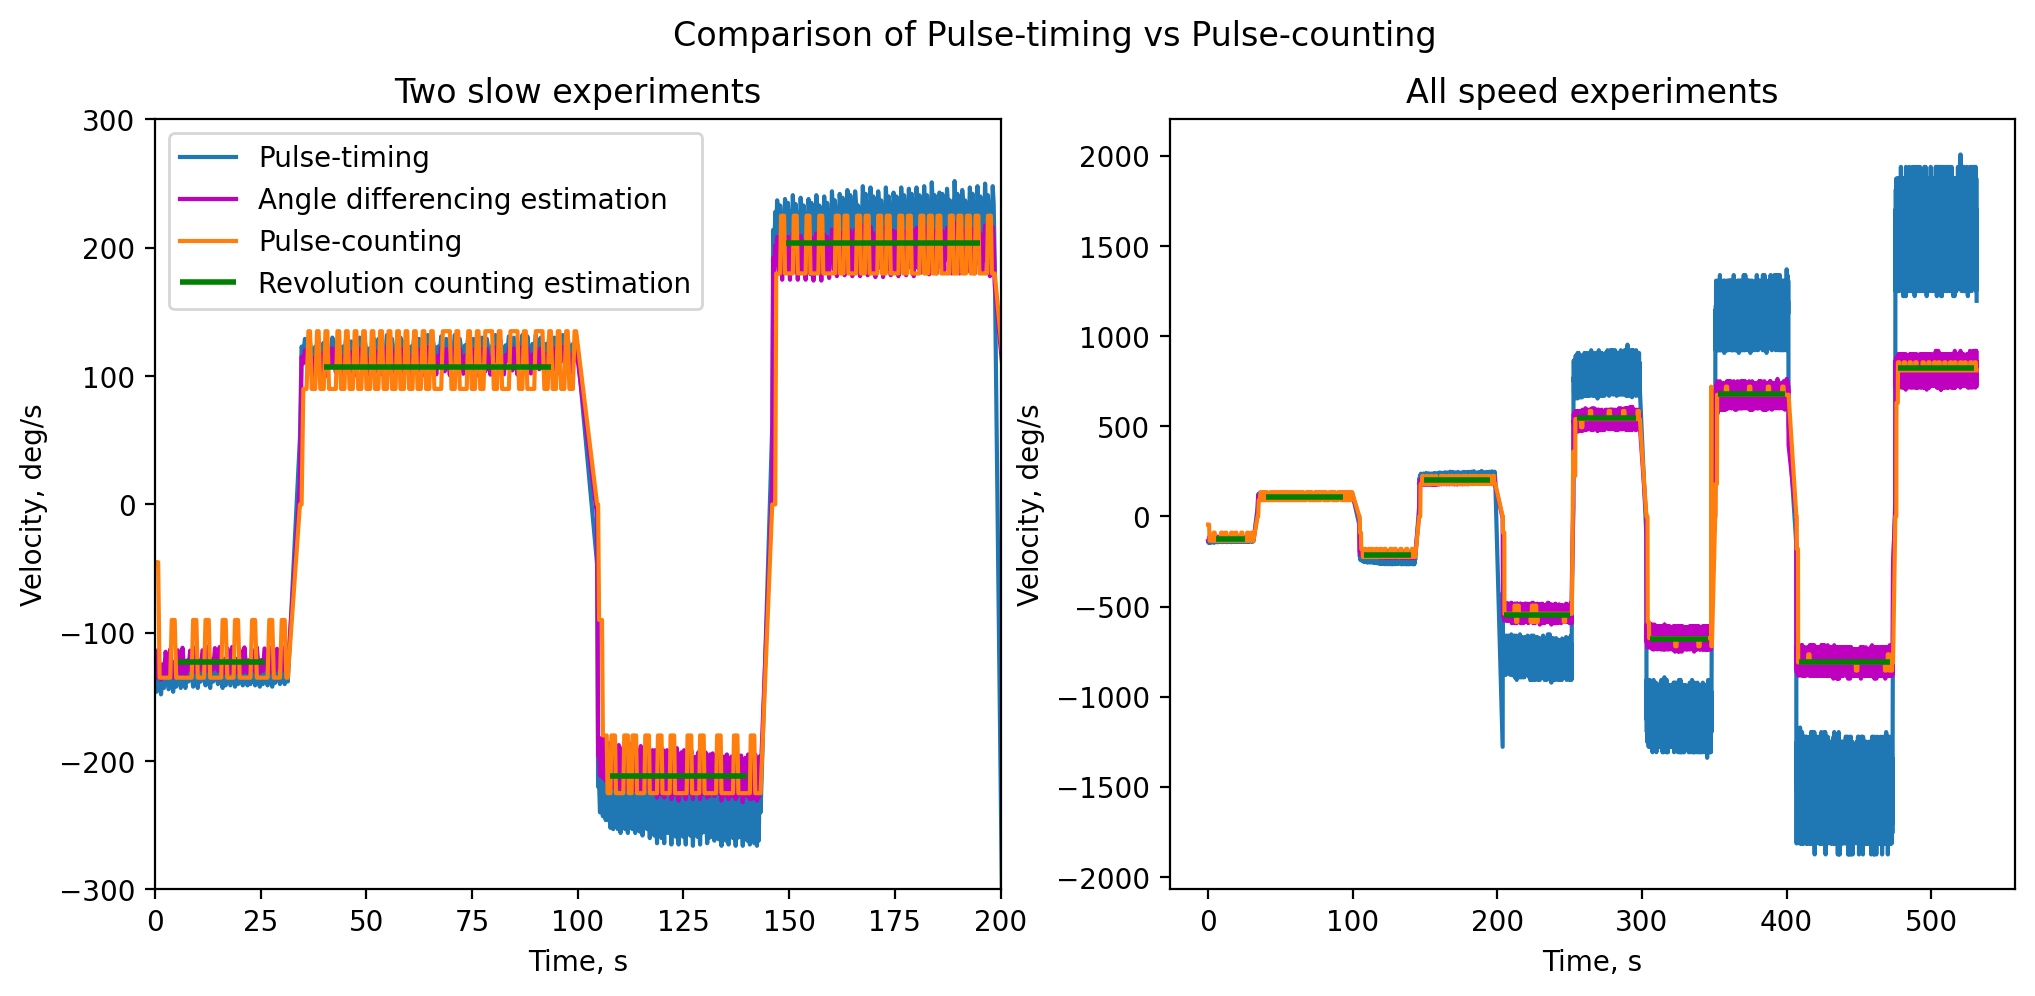

In [758]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fig.suptitle("Comparison of Pulse-timing vs Pulse-counting")

axes[0].set_title("Two slow experiments")
axes[0].plot(df.time/1e3, df.vel_pt, label='Pulse-timing')
axes[0].plot(df.time/1e3, ((df.angle.diff() + 180) % 360 - 180)/df.time.diff()*1e3, label='Derivative', c='m')
axes[0].plot(df.time/1e3, df.vel_pc, label='Pulse-counting')
for (st, en), ref_v in zip(exp_indeces, ref_speeds):
    axes[0].hlines(ref_v, df.time[st]/1e3, df.time[en]/1e3, color='g', label='Reference', linewidth=2)
axes[0].set_xlabel('Time, s')
axes[0].set_ylabel("Velocity, deg/s")
axes[0].set_xlim(0, 200)
axes[0].set_ylim(-300, 300)

axes[1].set_title("All speed experiments")
axes[1].plot(df.time/1e3, df.vel_pt, label='Pulse-timing')
axes[1].plot(df.time/1e3, ((df.angle.diff() + 180) % 360 - 180)/df.time.diff()*1e3, label='Derivative', c='m')
axes[1].plot(df.time/1e3, df.vel_pc, label='Pulse-counting')
for (st, en), ref_v in zip(exp_indeces, ref_speeds):
    axes[1].hlines(ref_v, df.time[st]/1e3, df.time[en]/1e3, color='g', label='Reference', linewidth=2)
axes[0].legend(['Pulse-timing', 'Angle differencing estimation', 'Pulse-counting', 'Revolution counting estimation'])
axes[1].set_xlabel('Time, s')
axes[1].set_ylabel("Velocity, deg/s")


<AxesSubplot: xlabel='vel', ylabel='Velocity Error Pulse-counting'>

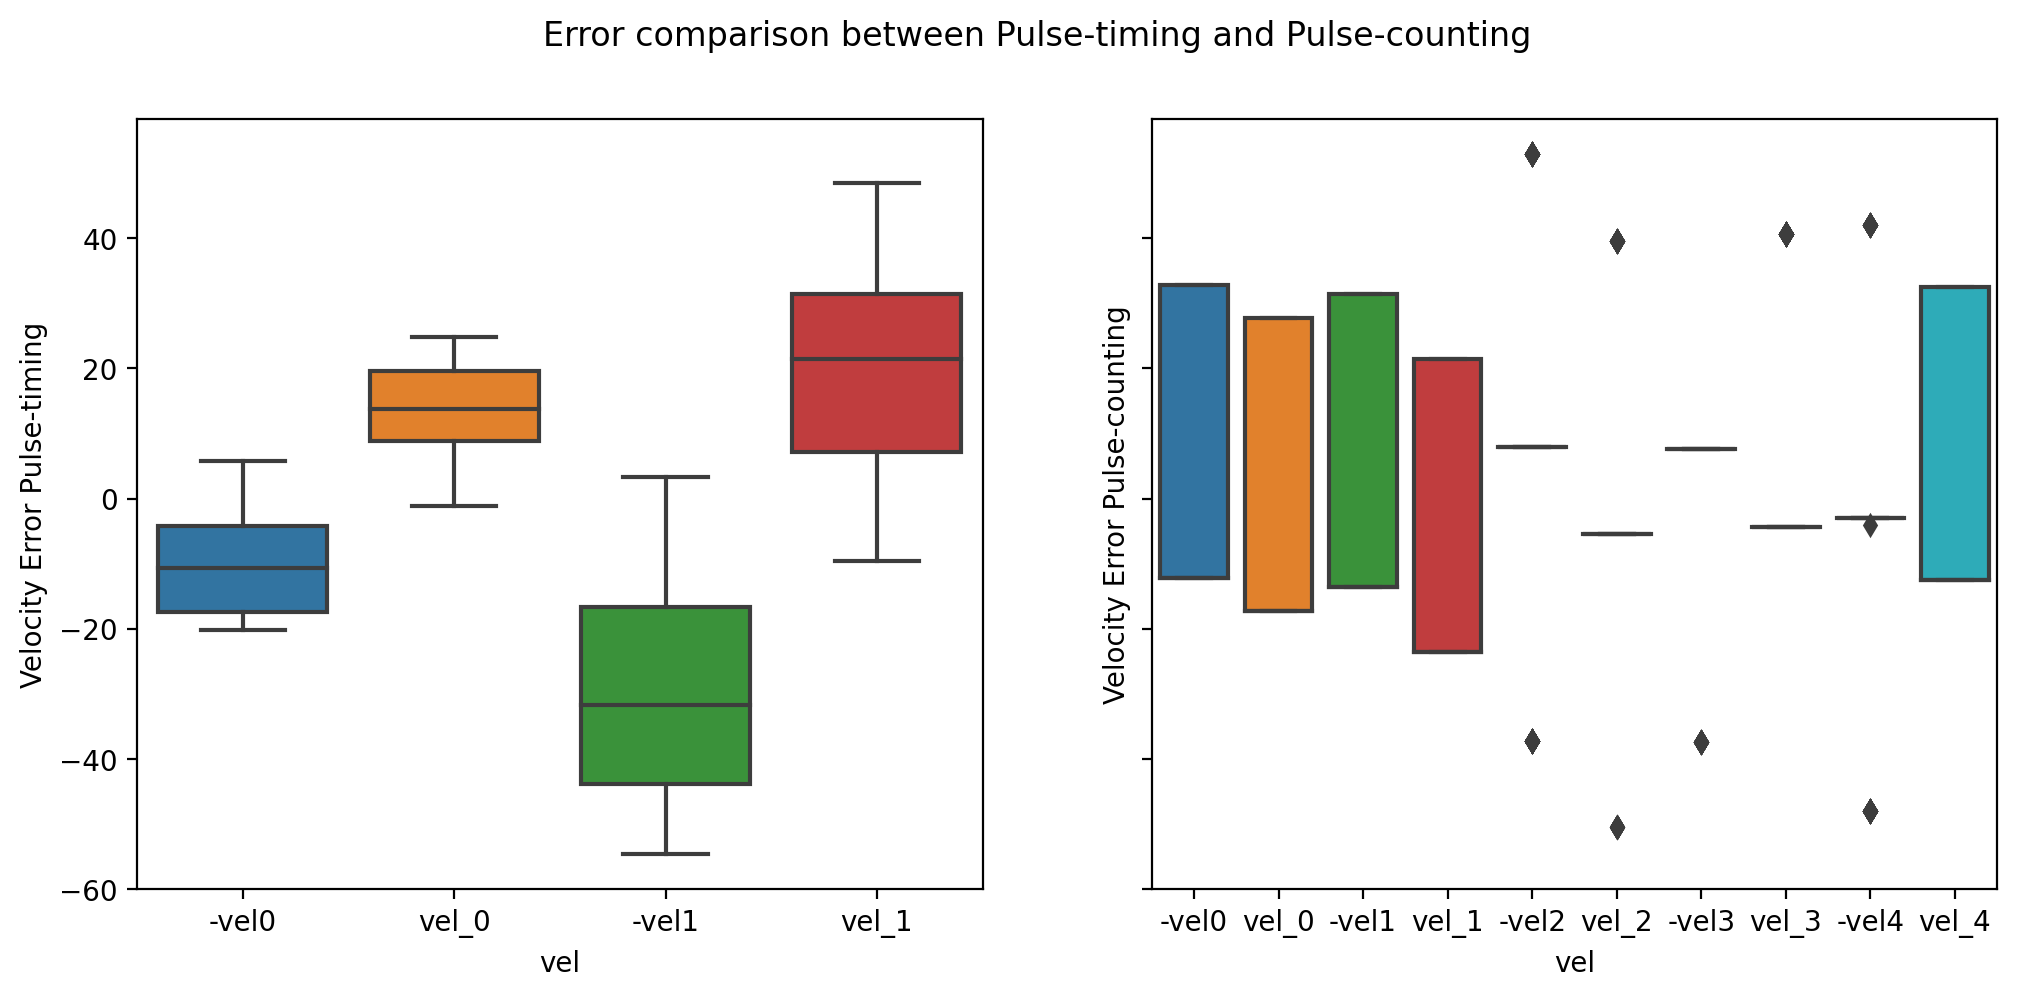

In [745]:
df_list = []
for idx, ((st, en), name, ref) in enumerate(zip(exp_indeces, exp_names, ref_speeds)):
    if idx >= 4:
        break
    df_list.append(pd.DataFrame({"Velocity Error Pulse-timing": (df.vel_pt[st:en] - ref), "vel": name}))

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle("Error comparison between Pulse-timing and Pulse-counting")
g = sns.boxplot(data=pd.concat(df_list), y='Velocity Error Pulse-timing', x='vel', ax=axes[0])

df_list = []
for (st, en), name, ref in zip(exp_indeces, exp_names, ref_speeds):
    df_list.append(pd.DataFrame({"Velocity Error Pulse-counting": (df.vel_pc[st:en] - ref), "vel": name}))

sns.boxplot(data=pd.concat(df_list), y='Velocity Error Pulse-counting', x='vel', ax=axes[1])